In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print("Current directory:", os.getcwd())
try:
    import comcloak
except ImportError as e:
    import sys
    sys.path.append("../")
# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    # os.system("pip install sionna")
    import sionna as sn

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
import numpy as np

# For plotting
%matplotlib inline 
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements 
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

NUM_BITS_PER_SYMBOL = 2 # QPSK


Current directory: d:\sionna-main\examples


In [2]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

In [3]:
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, block_length=1024)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5817e-01 | 1.0000e+00 |      323935 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -2.579 | 1.4676e-01 | 1.0000e+00 |      300565 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -2.158 | 1.3510e-01 | 1.0000e+00 |      276684 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -1.737 | 1.2338e-01 | 1.0000e+00 |      252692 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -1.316 | 1.1243e-01 | 1.0000e+00 |      230249 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -0.895 | 1.0106e-01 | 1.0000e+00 |      206968 |     2048000 |

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.15817139, 0.14676025, 0.13509961, 0.12338477, 0.11242627,
        0.10105859, 0.09006787, 0.0798877 , 0.06991797, 0.06085889,
        0.05194775, 0.04395703, 0.03679199, 0.02995996, 0.02418799,
        0.01918408, 0.01475879, 0.01114453, 0.00828174, 0.00587354])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 0.997])>)

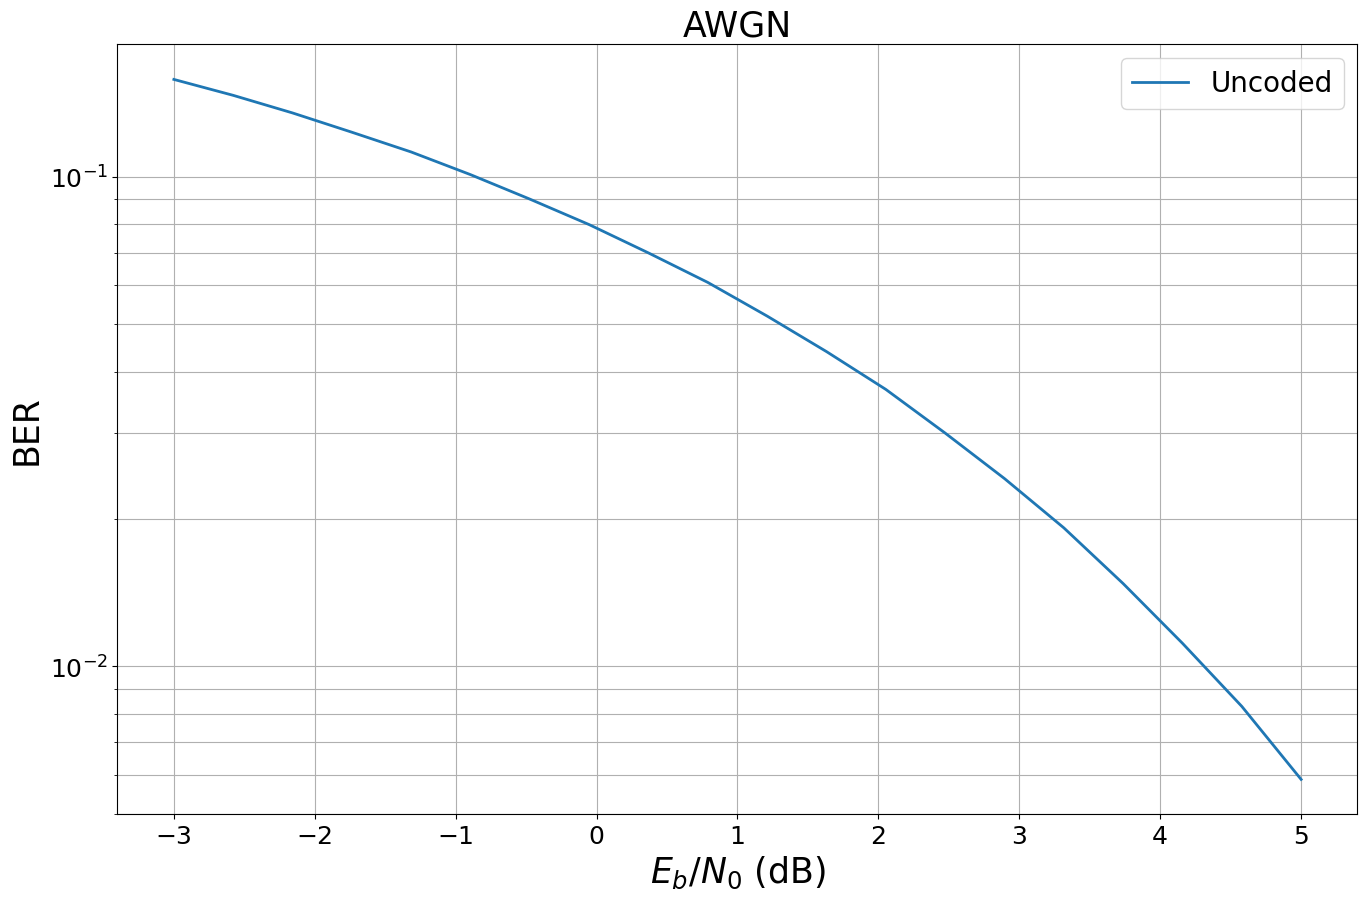

In [4]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=1000, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True,
                  real_time=False,
                  interval = 5)

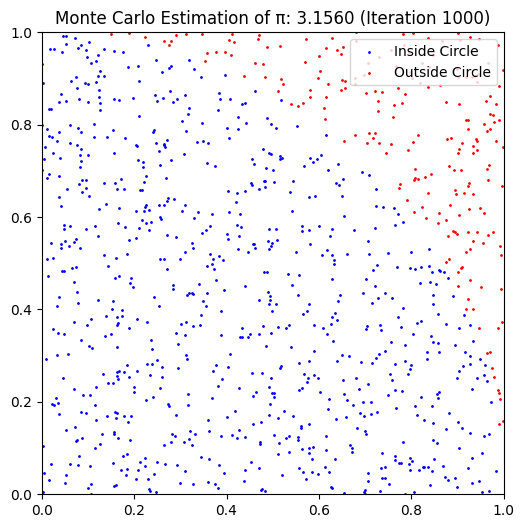

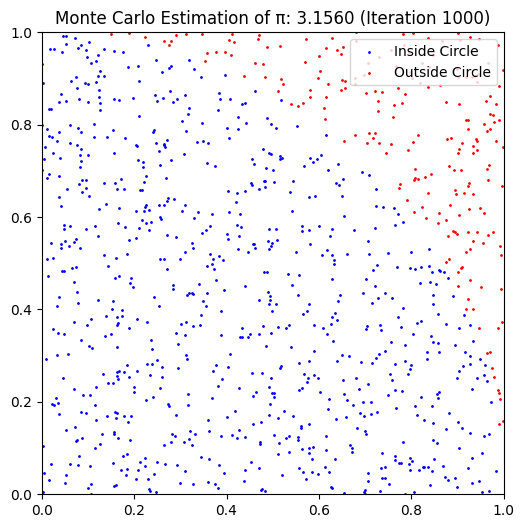

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


# 创建一个图形和轴
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.set_title('Monte Carlo Estimation of π')
ax.set_xlabel('x')
ax.set_ylabel('y')

# 初始化变量
num_samples = 1000  # 总的实验次数
points_inside_circle = 0
points_outside_circle = 0

# 用于存储点的列表
inside_x, inside_y = [], []
outside_x, outside_y = [], []

# 蒙特卡洛实验
for i in range(num_samples):
    # 随机生成一个点
    x = np.random.uniform(0, 1)
    y = np.random.uniform(0, 1)
    
    # 判断点是否在单位圆内
    if np.sqrt(x**2 + y**2) <= 1:
        points_inside_circle += 1
        inside_x.append(x)
        inside_y.append(y)
    else:
        points_outside_circle += 1
        outside_x.append(x)
        outside_y.append(y)
    
    # 每10次实验更新一次图像
    if (i + 1) % 10 == 0:
        # 清空当前轴
        ax.clear()
        
        # 绘制点
        ax.scatter(inside_x, inside_y, color='blue', s=1, label='Inside Circle')
        ax.scatter(outside_x, outside_y, color='red', s=1, label='Outside Circle')
        
        # 计算并显示当前的π估算值
        pi_estimate = 4 * points_inside_circle / (i + 1)
        ax.set_title(f'Monte Carlo Estimation of π: {pi_estimate:.4f} (Iteration {i + 1})')
        
        # 重新设置图形属性-
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal')
        ax.legend()
        # 立即更新窗口
        clear_output(wait=True)  # 清空输出
        display(fig)  # 重新显示


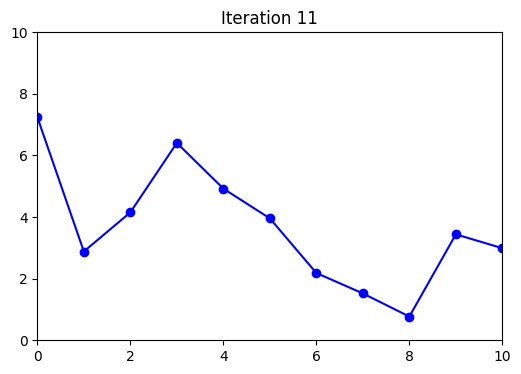

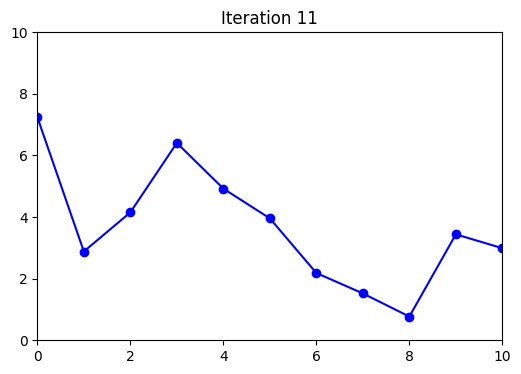

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# 创建画布和轴
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title("Real-time Line Plot")

x_data, y_data = [], []  # 用于存储数据

# 实时绘制折线图
for i in range(11):  # 模拟计算 11 个点
    x_data.append(i)
    y_data.append(np.random.uniform(0, 10))  # 随机生成 y 值

    ax.clear()  # 清空旧图
    ax.plot(x_data, y_data, marker="o", color="b", linestyle="-")  # 绘制折线
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_title(f"Iteration {i+1}")

    clear_output(wait=True)  # 清除上一个输出
    display(fig)  # 重新显示图像
    time.sleep(0.5)  # 模拟计算时间

plt.show()  # 结束时显示最终图像
